In [1]:
import pandas as pd
from io import StringIO
import requests
from datetime import datetime, timedelta

In [2]:
def get_stock_data(ticker, site='stooq', months=3):
    """
    Get stock data with automatic date column detection
    
    Parameters:
    ticker (str): Stock ticker (e.g., 'NVDA')
    site (str): Data source ('stooq')
    months (int): Number of months of data to fetch (default 3)
    """
    
    if site == 'stooq':
        # Add .US suffix if not present
        ticker = ticker = 'NVDA' + '.US' if '.' not in ticker else ticker
        url = f"https://stooq.com/q/d/l/?s={ticker}&i=d"
        
        try:
            response = requests.get(url)
            response.raise_for_status()
            df = pd.read_csv(StringIO(response.text))
            
            # Print column names to see what we got
            print("Columns in dataset:", df.columns.tolist())
            
            # Find the date column (could be 'Date', 'date', or index)
            date_col = None
            for col in df.columns:
                if 'date' in col.lower():
                    date_col = col
                    break
            
            if date_col:
                df[date_col] = pd.to_datetime(df[date_col])
                df = df.sort_values(date_col).reset_index(drop=True)
                
                # Filter for last X months
                cutoff_date = datetime.now() - timedelta(days=months*30)
                df = df[df[date_col] >= cutoff_date]
                
                # Rename to standard 'Date'
                df = df.rename(columns={date_col: 'Date'})
            else:
                print("Warning: No date column found")
            
            print(f"\n✓ Fetched {len(df)} records from Stooq for {ticker}")
            print(f"  Date range: {df['Date'].min().date()} to {df['Date'].max().date()}")
            print(f"  Columns: {df.columns.tolist()}")
            
            return df
            
        except Exception as e:
            print(f"✗ Error: {e}")
            return None
    
    return None

In [4]:
# Usage
df = get_stock_data('NVDA', 'stooq', months=3)

if df is not None:
    print("\n--- First 5 rows ---")
    print(df.head())
    print("\n--- Last 5 rows ---")
    print(df.tail())
    print("\n--- Dataset Info ---")
    print(df.info())

Columns in dataset: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']

✓ Fetched 62 records from Stooq for NVDA.US
  Date range: 2025-08-28 to 2025-11-24
  Columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']

--- First 5 rows ---
           Date    Open     High      Low   Close     Volume
6690 2025-08-28  180.82  184.470  176.410  180.17  281787824
6691 2025-08-29  178.11  178.150  173.145  174.18  243257873
6692 2025-09-02  170.00  172.379  167.220  170.78  231164853
6693 2025-09-03  171.06  172.410  168.875  170.62  164424873
6694 2025-09-04  170.57  171.860  169.410  171.66  141670144

--- Last 5 rows ---
           Date     Open     High       Low   Close     Volume
6747 2025-11-18  183.375  184.800  179.6500  181.36  213598877
6748 2025-11-19  184.790  187.855  182.8301  186.52  247246436
6749 2025-11-20  195.950  196.000  179.8500  180.64  343504849
6750 2025-11-21  181.235  184.560  172.9300  178.88  346926153
6751 2025-11-24  179.490  183.500  176.4800  182.55  256618

In [5]:
# Check for any issues in the data
print("=== Data Cleaning Check ===\n")

# 1. Check for missing values
print("Missing values:")
print(df.isnull().sum())
print()

# 2. Check for duplicates
duplicates = df.duplicated().sum()
print(f"Duplicate rows: {duplicates}")
print()

# 3. Check data types
print("Data types:")
print(df.dtypes)
print()

# 4. Basic statistics
print("Basic Statistics:")
print(df.describe())
print()


=== Data Cleaning Check ===

Missing values:
Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

Duplicate rows: 0

Data types:
Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume             int64
dtype: object

Basic Statistics:
                                Date        Open        High         Low  \
count                             62   62.000000   62.000000   62.000000   
mean   2025-10-11 10:27:05.806451712  184.522258  186.963850  181.295765   
min              2025-08-28 00:00:00  167.550000  169.030000  164.070000   
25%              2025-09-19 18:00:00  178.125000  179.900000  175.235000   
50%              2025-10-11 12:00:00  182.995000  184.835000  179.795050   
75%              2025-11-02 06:00:00  189.892500  191.342500  185.815000   
max              2025-11-24 00:00:00  208.080000  212.189900  205.560000   
std                              NaN    9.87243

In [6]:
# 5. Remove duplicates if any
#df = df.drop_duplicates()

# 6. Ensure data is sorted by date (already done, but confirming)
df = df.sort_values('Date').reset_index(drop=True)

# 7. Check for any negative values (shouldn't exist in stock data)
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
for col in numeric_cols:
    negative_count = (df[col] < 0).sum()
    if negative_count > 0:
        print(f"⚠️ Warning: {negative_count} negative values in {col}")

print("✓ Data cleaning complete!")
print(f"Final dataset: {len(df)} rows × {len(df.columns)} columns")

✓ Data cleaning complete!
Final dataset: 62 rows × 6 columns


In [7]:
import os

# Define your project folder
project_folder = r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis'

# Save the cleaned data
file_path = os.path.join(project_folder, 'nvidia_cleaned.csv')
df.to_csv(file_path, index=False)

print(f"✓ Saved cleaned data to: {file_path}")

✓ Saved cleaned data to: C:\Emaad\Nvidia Stocks Data Time-Series Analysis\nvidia_cleaned.csv


In [8]:
# Load the cleaned data
df = pd.read_csv(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\nvidia_cleaned.csv')
df['Date'] = pd.to_datetime(df['Date'])

print("=== Creating Financial Features ===\n")

# 1. Moving Averages
df['SMA_5'] = df['Close'].rolling(window=5).mean()  # 5-day Simple Moving Average
df['SMA_10'] = df['Close'].rolling(window=10).mean()  # 10-day SMA
df['EMA_5'] = df['Close'].ewm(span=5, adjust=False).mean()  # 5-day Exponential MA
df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()  # 10-day EMA

# 2. Volatility (Standard Deviation)
df['Volatility_5'] = df['Close'].rolling(window=5).std()
df['Volatility_10'] = df['Close'].rolling(window=10).std()

# 3. Daily Returns (Percentage change)
df['Daily_Return'] = df['Close'].pct_change() * 100

# 4. Price Range & Body
df['High_Low_Range'] = df['High'] - df['Low']  # Daily range
df['Body'] = abs(df['Close'] - df['Open'])  # Candle body size
df['Upper_Shadow'] = df['High'] - df[['Open', 'Close']].max(axis=1)  # Upper wick
df['Lower_Shadow'] = df[['Open', 'Close']].min(axis=1) - df['Low']  # Lower wick

# 5. Relative Strength Index (RSI) - 14 day
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI_14'] = calculate_rsi(df['Close'])

# 6. MACD (Moving Average Convergence Divergence)
exp1 = df['Close'].ewm(span=12, adjust=False).mean()
exp2 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = exp1 - exp2
df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

# 7. Bollinger Bands
df['BB_Middle'] = df['Close'].rolling(window=20).mean()
bb_std = df['Close'].rolling(window=20).std()
df['BB_Upper'] = df['BB_Middle'] + (bb_std * 2)
df['BB_Lower'] = df['BB_Middle'] - (bb_std * 2)

# 8. Lag features (previous day values)
df['Close_Lag1'] = df['Close'].shift(1)
df['Close_Lag2'] = df['Close'].shift(2)
df['Volume_Lag1'] = df['Volume'].shift(1)

# 9. Rolling statistics
df['Close_Rolling_Max_10'] = df['Close'].rolling(window=10).max()
df['Close_Rolling_Min_10'] = df['Close'].rolling(window=10).min()

print("✓ Created all financial features!")
print(f"\nTotal features now: {len(df.columns)}")
print(f"Feature names: {df.columns.tolist()}")

# Drop rows with NaN values created by rolling calculations
print(f"\nRows before dropping NaN: {len(df)}")
df = df.dropna()
print(f"Rows after dropping NaN: {len(df)}")

# Save with features
feature_file = r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\nvidia_with_features.csv'
df.to_csv(feature_file, index=False)
print(f"\n✓ Saved data with features to: {feature_file}")

# Display first few rows
print("\n--- Sample of data with features ---")
print(df.head())

=== Creating Financial Features ===

✓ Created all financial features!

Total features now: 28
Feature names: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'SMA_5', 'SMA_10', 'EMA_5', 'EMA_10', 'Volatility_5', 'Volatility_10', 'Daily_Return', 'High_Low_Range', 'Body', 'Upper_Shadow', 'Lower_Shadow', 'RSI_14', 'MACD', 'MACD_Signal', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'Close_Lag1', 'Close_Lag2', 'Volume_Lag1', 'Close_Rolling_Max_10', 'Close_Rolling_Min_10']

Rows before dropping NaN: 62
Rows after dropping NaN: 43

✓ Saved data with features to: C:\Emaad\Nvidia Stocks Data Time-Series Analysis\nvidia_with_features.csv

--- Sample of data with features ---
         Date     Open    High      Low   Close     Volume    SMA_5   SMA_10  \
19 2025-09-25  174.480  180.26  173.125  177.69  191586733  178.674  177.035   
20 2025-09-26  178.170  179.77  174.930  178.19  148573732  178.978  177.072   
21 2025-09-29  180.425  184.00  180.320  181.85  193063455  178.626  177.482   
22 2025-09-

=== Creating Visualizations ===



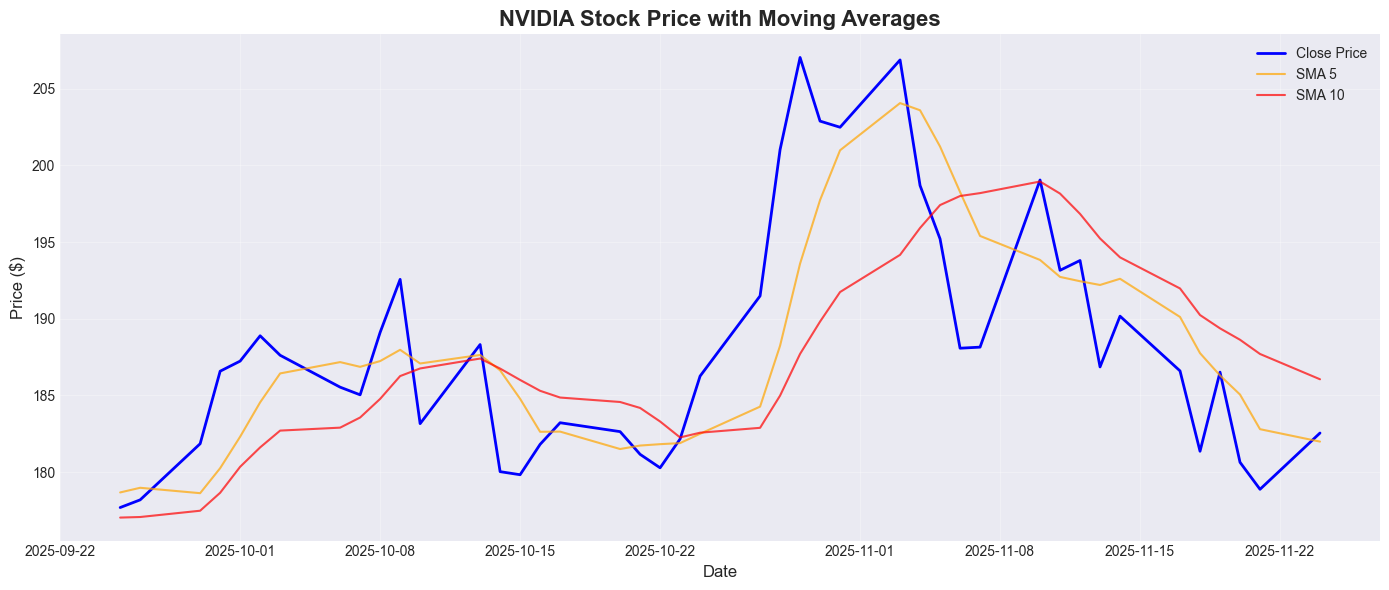

✓ Saved: 1_price_with_ma.png


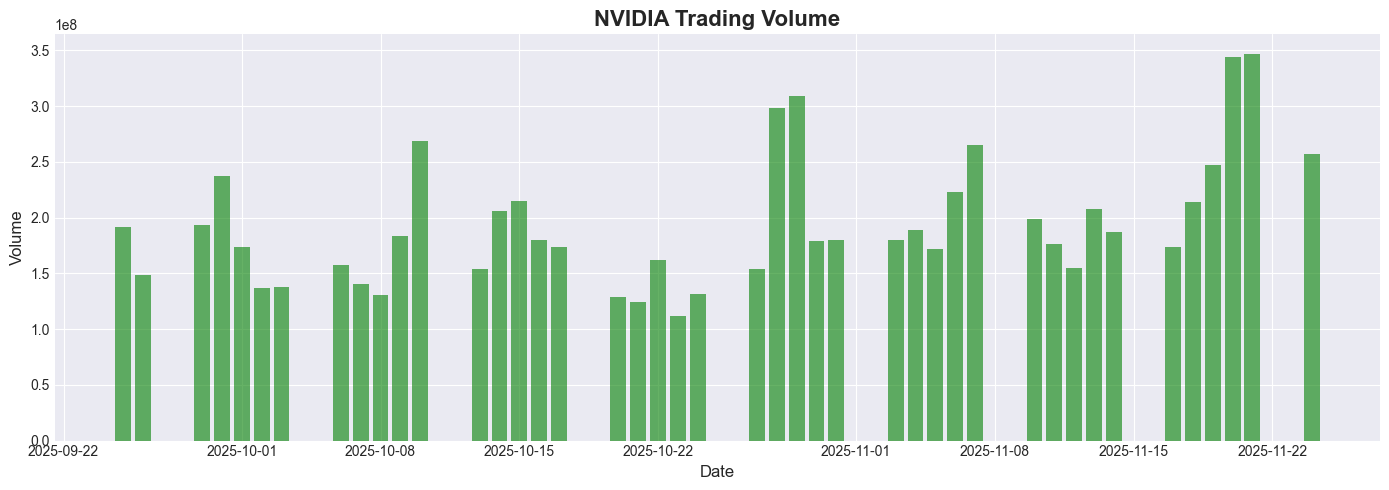

✓ Saved: 2_volume.png


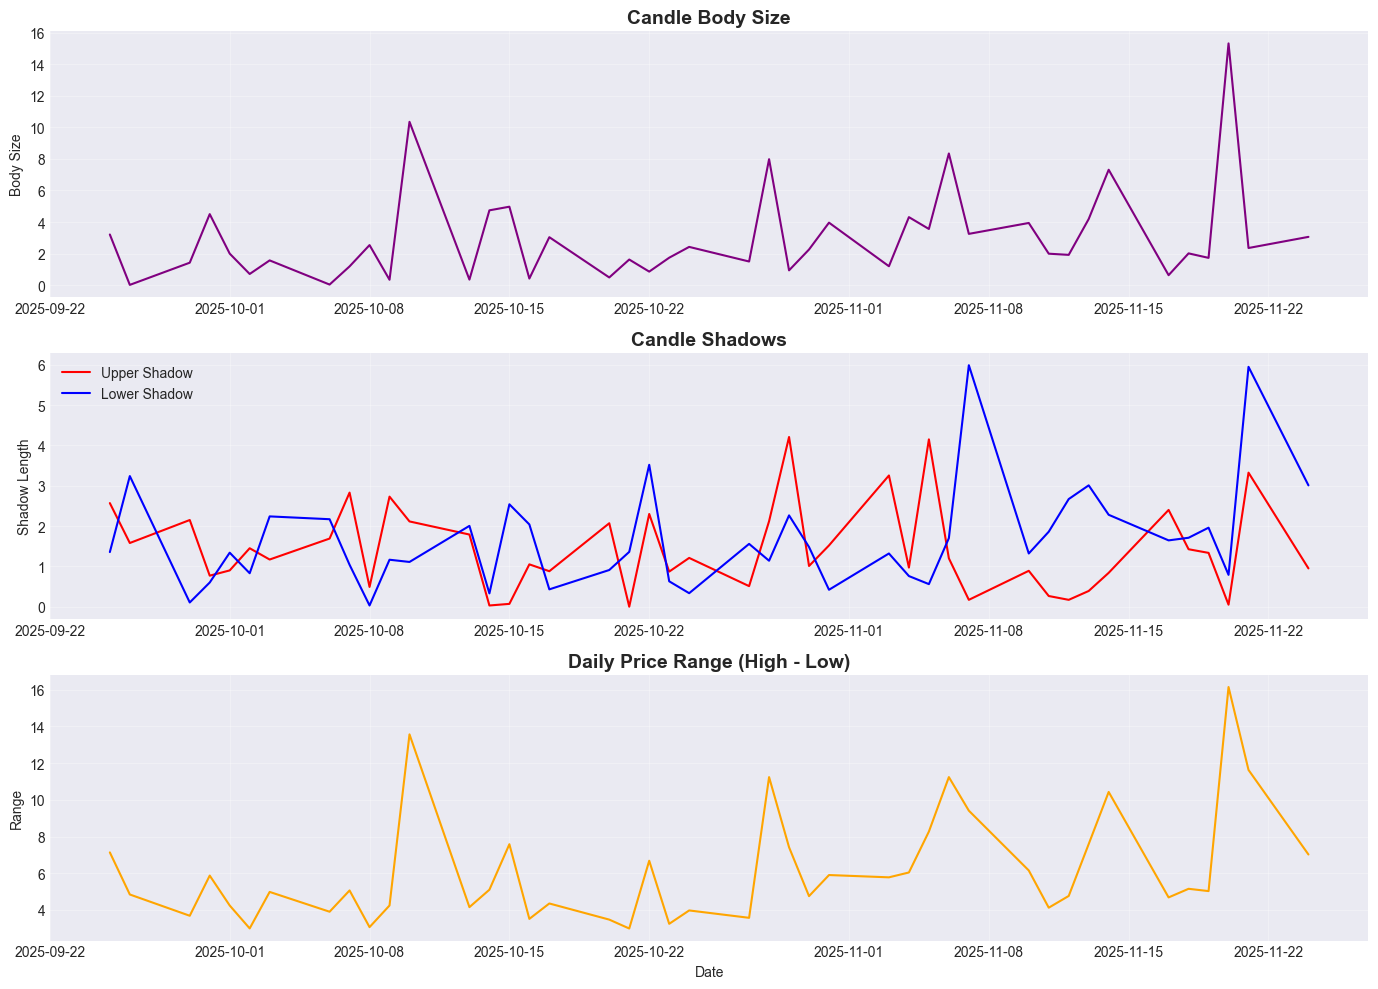

✓ Saved: 3_candlestick_features.png


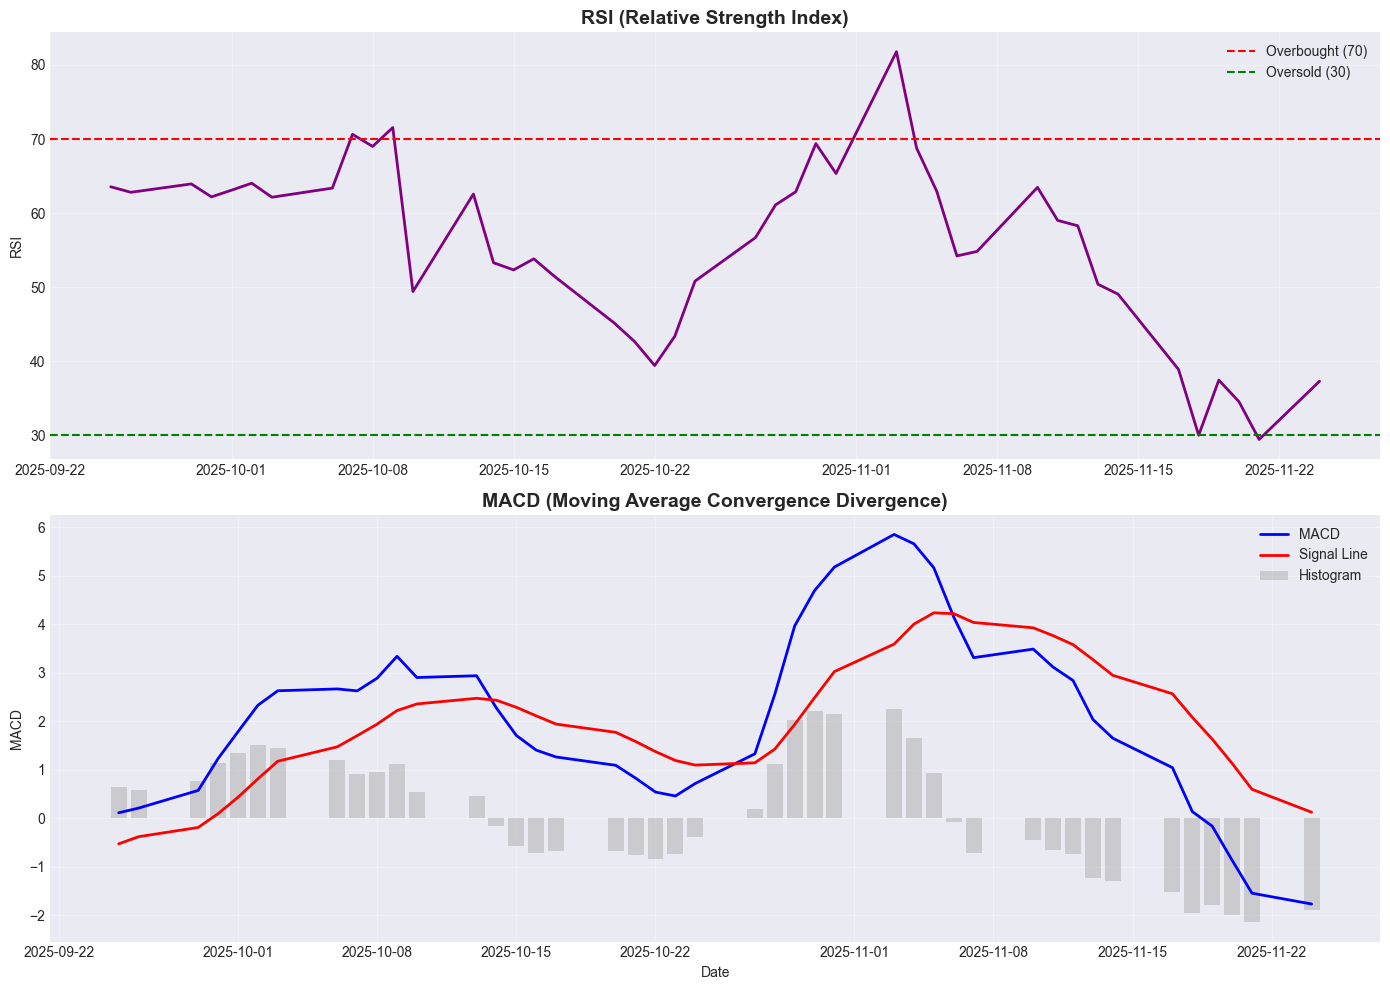

✓ Saved: 4_technical_indicators.png


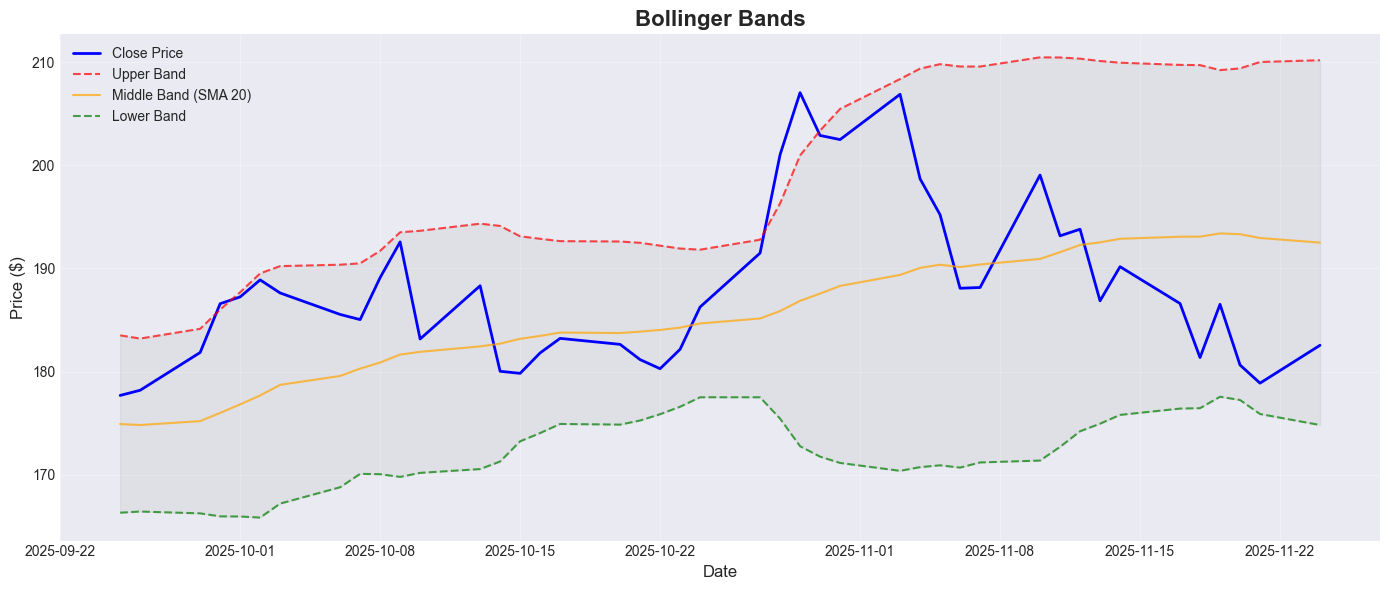

✓ Saved: 5_bollinger_bands.png


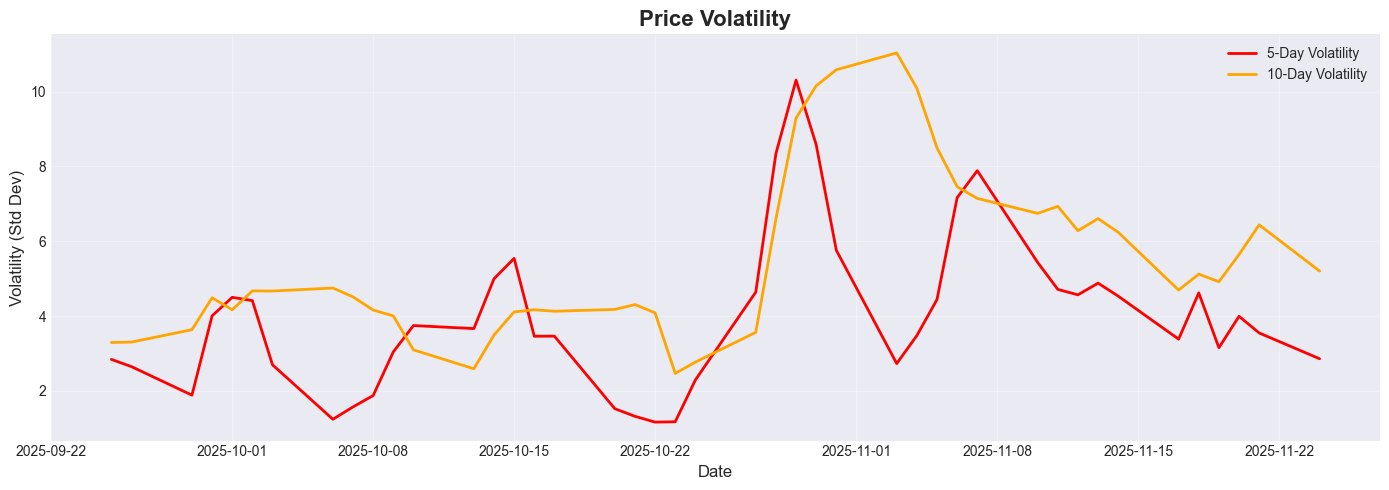

✓ Saved: 6_volatility.png


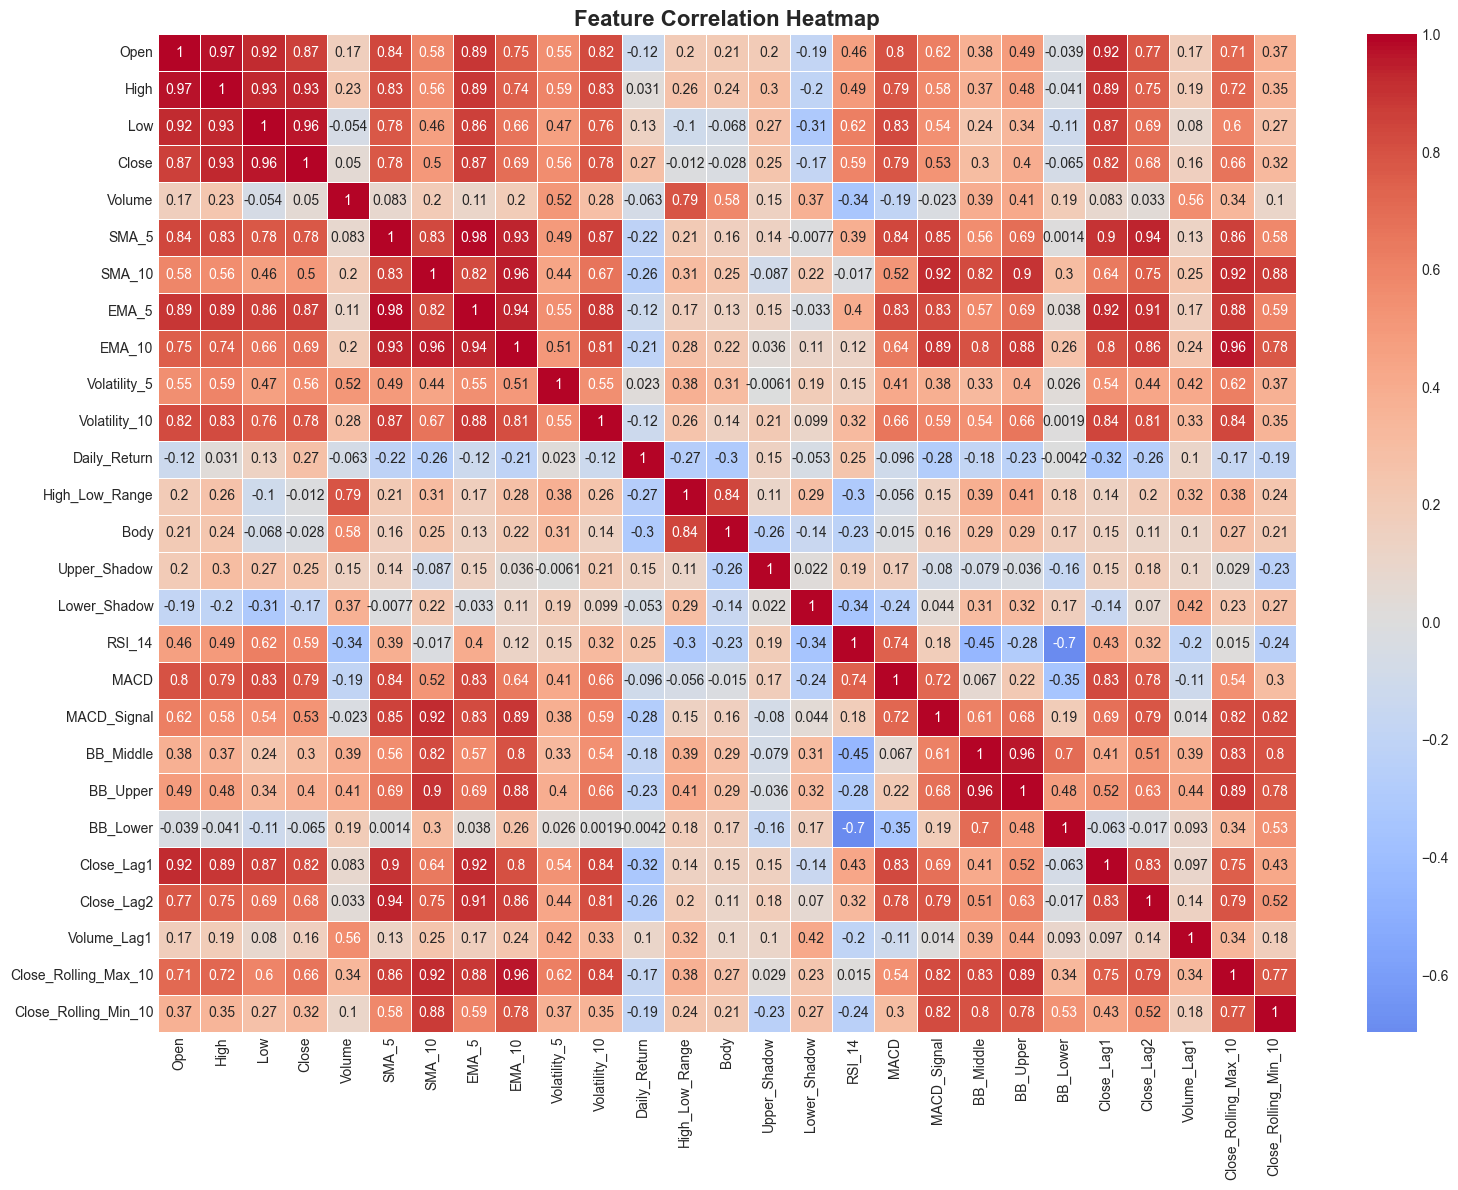

✓ Saved: 7_correlation_heatmap.png


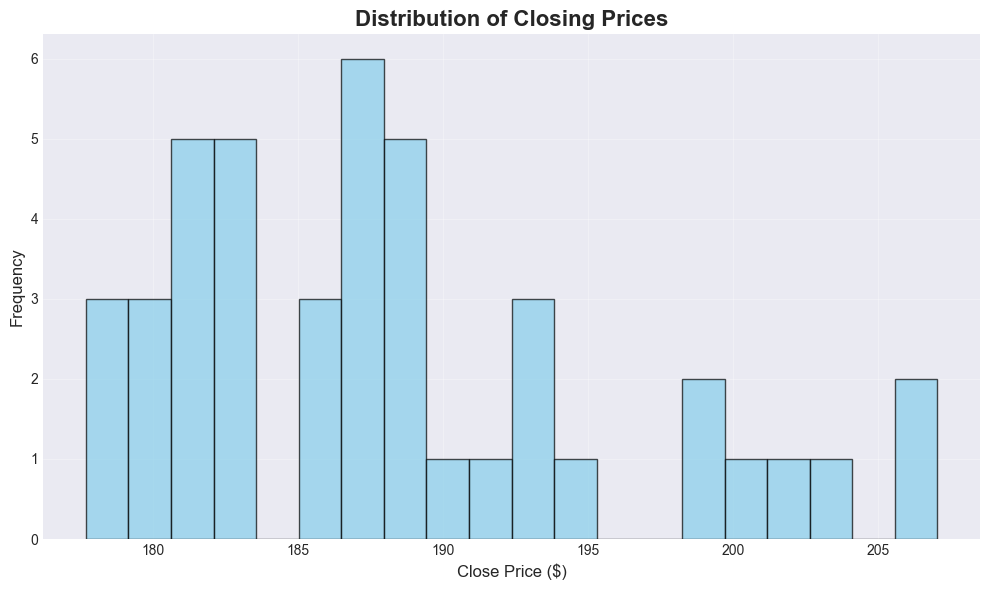

✓ Saved: 8_price_distribution.png

✓ All visualizations created and saved!


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load the feature data
df = pd.read_csv(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\nvidia_with_features.csv')
df['Date'] = pd.to_datetime(df['Date'])

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("=== Creating Visualizations ===\n")

# 1. Closing Price Over Time
plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['Close'], linewidth=2, label='Close Price', color='blue')
plt.plot(df['Date'], df['SMA_5'], linewidth=1.5, label='SMA 5', color='orange', alpha=0.7)
plt.plot(df['Date'], df['SMA_10'], linewidth=1.5, label='SMA 10', color='red', alpha=0.7)
plt.title('NVIDIA Stock Price with Moving Averages', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\1_price_with_ma.png', dpi=300)
plt.show()
print("✓ Saved: 1_price_with_ma.png")

# 2. Volume Traded Over Time
plt.figure(figsize=(14, 5))
plt.bar(df['Date'], df['Volume'], color='green', alpha=0.6)
plt.title('NVIDIA Trading Volume', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volume', fontsize=12)
plt.tight_layout()
plt.savefig(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\2_volume.png', dpi=300)
plt.show()
print("✓ Saved: 2_volume.png")

# 3. Candlestick Features (Body, Shadows, Range)
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

axes[0].plot(df['Date'], df['Body'], color='purple', linewidth=1.5)
axes[0].set_title('Candle Body Size', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Body Size', fontsize=10)
axes[0].grid(True, alpha=0.3)

axes[1].plot(df['Date'], df['Upper_Shadow'], color='red', linewidth=1.5, label='Upper Shadow')
axes[1].plot(df['Date'], df['Lower_Shadow'], color='blue', linewidth=1.5, label='Lower Shadow')
axes[1].set_title('Candle Shadows', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Shadow Length', fontsize=10)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].plot(df['Date'], df['High_Low_Range'], color='orange', linewidth=1.5)
axes[2].set_title('Daily Price Range (High - Low)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Date', fontsize=10)
axes[2].set_ylabel('Range', fontsize=10)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\3_candlestick_features.png', dpi=300)
plt.show()
print("✓ Saved: 3_candlestick_features.png")

# 4. Technical Indicators
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# RSI
axes[0].plot(df['Date'], df['RSI_14'], color='purple', linewidth=2)
axes[0].axhline(y=70, color='r', linestyle='--', label='Overbought (70)')
axes[0].axhline(y=30, color='g', linestyle='--', label='Oversold (30)')
axes[0].set_title('RSI (Relative Strength Index)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('RSI', fontsize=10)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# MACD
axes[1].plot(df['Date'], df['MACD'], label='MACD', linewidth=2, color='blue')
axes[1].plot(df['Date'], df['MACD_Signal'], label='Signal Line', linewidth=2, color='red')
axes[1].bar(df['Date'], df['MACD'] - df['MACD_Signal'], label='Histogram', alpha=0.3, color='gray')
axes[1].set_title('MACD (Moving Average Convergence Divergence)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=10)
axes[1].set_ylabel('MACD', fontsize=10)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\4_technical_indicators.png', dpi=300)
plt.show()
print("✓ Saved: 4_technical_indicators.png")

# 5. Bollinger Bands
plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['Close'], label='Close Price', linewidth=2, color='blue')
plt.plot(df['Date'], df['BB_Upper'], label='Upper Band', linewidth=1.5, color='red', linestyle='--', alpha=0.7)
plt.plot(df['Date'], df['BB_Middle'], label='Middle Band (SMA 20)', linewidth=1.5, color='orange', alpha=0.7)
plt.plot(df['Date'], df['BB_Lower'], label='Lower Band', linewidth=1.5, color='green', linestyle='--', alpha=0.7)
plt.fill_between(df['Date'], df['BB_Upper'], df['BB_Lower'], alpha=0.1, color='gray')
plt.title('Bollinger Bands', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\5_bollinger_bands.png', dpi=300)
plt.show()
print("✓ Saved: 5_bollinger_bands.png")

# 6. Volatility
plt.figure(figsize=(14, 5))
plt.plot(df['Date'], df['Volatility_5'], label='5-Day Volatility', linewidth=2, color='red')
plt.plot(df['Date'], df['Volatility_10'], label='10-Day Volatility', linewidth=2, color='orange')
plt.title('Price Volatility', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volatility (Std Dev)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\6_volatility.png', dpi=300)
plt.show()
print("✓ Saved: 6_volatility.png")

# 7. Correlation Heatmap
plt.figure(figsize=(16, 12))
correlation_matrix = df.drop(['Date'], axis=1).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Feature Correlation Heatmap', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\7_correlation_heatmap.png', dpi=300)
plt.show()
print("✓ Saved: 7_correlation_heatmap.png")

# 8. Distribution of Close Prices
plt.figure(figsize=(10, 6))
plt.hist(df['Close'], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Closing Prices', fontsize=16, fontweight='bold')
plt.xlabel('Close Price ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\8_price_distribution.png', dpi=300)
plt.show()
print("✓ Saved: 8_price_distribution.png")

print("\n✓ All visualizations created and saved!")

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load the feature data
df = pd.read_csv(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\nvidia_with_features.csv')
df['Date'] = pd.to_datetime(df['Date'])

print("=== Train-Test Split ===\n")
print(f"Total data points: {len(df)}")

# Define features and target
target_column = 'Close'
feature_columns = [col for col in df.columns if col not in ['Date', 'Close']]

print(f"\nTarget variable: {target_column}")
print(f"Number of features: {len(feature_columns)}")

# Split ratio (80% train, 20% test)
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size

print(f"\nTrain size: {train_size} rows ({train_size/len(df)*100:.1f}%)")
print(f"Test size: {test_size} rows ({test_size/len(df)*100:.1f}%)")

# Split the data sequentially
train_df = df[:train_size].copy()
test_df = df[train_size:].copy()

print(f"\nTrain date range: {train_df['Date'].min().date()} to {train_df['Date'].max().date()}")
print(f"Test date range: {test_df['Date'].min().date()} to {test_df['Date'].max().date()}")

# Separate features and target
X_train = train_df[feature_columns]
y_train = train_df[target_column]

X_test = test_df[feature_columns]
y_test = test_df[target_column]

# Scale the features (important for neural networks)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

print("\n✓ Data scaled using MinMaxScaler")
print(f"X_train shape: {X_train_scaled.shape}")
print(f"X_test shape: {X_test_scaled.shape}")
print(f"y_train shape: {y_train_scaled.shape}")
print(f"y_test shape: {y_test_scaled.shape}")

# Save the split data for model training
np.save(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\X_train_scaled.npy', X_train_scaled)
np.save(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\X_test_scaled.npy', X_test_scaled)
np.save(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\y_train_scaled.npy', y_train_scaled)
np.save(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\y_test_scaled.npy', y_test_scaled)

# Also save unscaled versions for evaluation
np.save(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\y_train.npy', y_train.values)
np.save(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\y_test.npy', y_test.values)

# Save train/test dates for later plotting
train_df[['Date', 'Close']].to_csv(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\train_dates.csv', index=False)
test_df[['Date', 'Close']].to_csv(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\test_dates.csv', index=False)

print("\n✓ Saved all train/test data!")
print("\nFiles created:")
print("- X_train_scaled.npy, X_test_scaled.npy")
print("- y_train_scaled.npy, y_test_scaled.npy")
print("- y_train.npy, y_test.npy")
print("- train_dates.csv, test_dates.csv")

# Save the scalers for inverse transformation later
import pickle
with open(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\scaler_X.pkl', 'wb') as f:
    pickle.dump(scaler_X, f)
with open(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\scaler_y.pkl', 'wb') as f:
    pickle.dump(scaler_y, f)

print("- scaler_X.pkl, scaler_y.pkl")
print("\n✓ Train-Test split complete!")

=== Train-Test Split ===

Total data points: 43

Target variable: Close
Number of features: 26

Train size: 34 rows (79.1%)
Test size: 9 rows (20.9%)

Train date range: 2025-09-25 to 2025-11-11
Test date range: 2025-11-12 to 2025-11-24

✓ Data scaled using MinMaxScaler
X_train shape: (34, 26)
X_test shape: (9, 26)
y_train shape: (34, 1)
y_test shape: (9, 1)

✓ Saved all train/test data!

Files created:
- X_train_scaled.npy, X_test_scaled.npy
- y_train_scaled.npy, y_test_scaled.npy
- y_train.npy, y_test.npy
- train_dates.csv, test_dates.csv
- scaler_X.pkl, scaler_y.pkl

✓ Train-Test split complete!


=== Building LSTM Model ===

X_train_lstm shape: (34, 1, 26)
X_test_lstm shape: (9, 1, 26)

--- LSTM Model Architecture ---


c:\Python 3.10.11 Downlaod\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 50)          │        15,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,901 (144.14 KB)

 Trainable params: 36,901 (144.14 KB)

 Non-trainable params: 0 (0.00 B)


--- Training LSTM Model ---
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 383ms/step - loss: 0.1714 - mae: 0.3204 - val_loss: 0.3959 - val_mae: 0.5929
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.1635 - mae: 0.3076 - val_loss: 0.3778 - val_mae: 0.5775
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.1543 - mae: 0.2964 - val_loss: 0.3599 - val_mae: 0.5617
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.1452 - mae: 0.2833 - val_loss: 0.3416 - val_mae: 0.5452
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.1388 - mae: 0.2733 - val_loss: 0.3226 - val_mae: 0.5275
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.1291 - mae: 0.2571 - val_loss: 0.3020 - val_mae: 0.5076
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.1183 - mae: 0.2435 - val_loss: 0.2794 - val_mae: 0.4850
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.1108 - mae: 0.2349 - val_loss: 0.2553 - val_mae: 0.4596
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66

✓ Saved LSTM predictions and model!


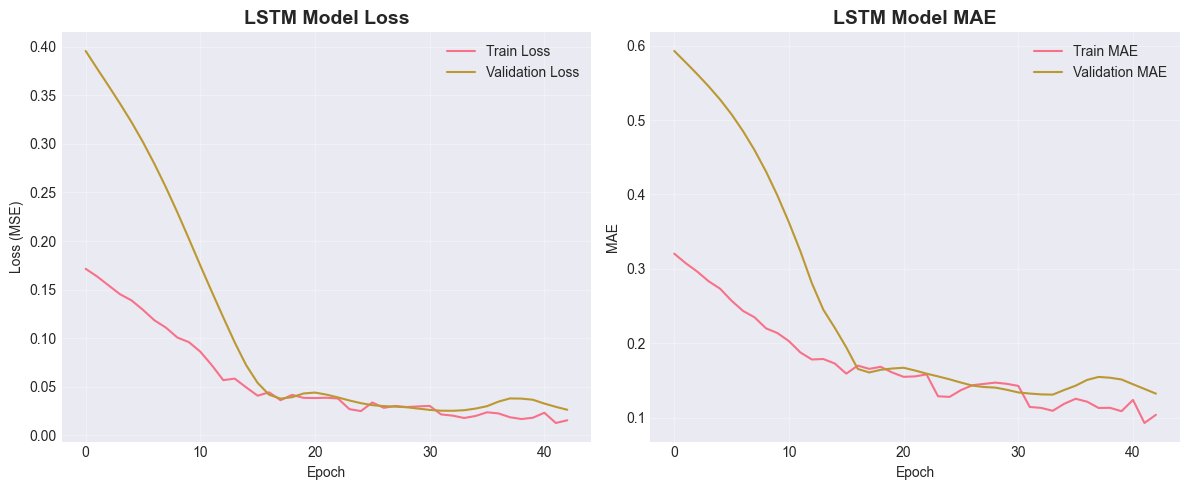


✓ LSTM model complete!


In [11]:
import numpy as np
import pandas as pd
import pickle
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

print("=== Building LSTM Model ===\n")

# Load the scaled data
X_train_scaled = np.load(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\X_train_scaled.npy')
X_test_scaled = np.load(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\X_test_scaled.npy')
y_train_scaled = np.load(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\y_train_scaled.npy')
y_test_scaled = np.load(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\y_test_scaled.npy')

# Reshape for LSTM [samples, timesteps, features]
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

print(f"X_train_lstm shape: {X_train_lstm.shape}")
print(f"X_test_lstm shape: {X_test_lstm.shape}")

# Build LSTM model
model_lstm = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(1, X_train_scaled.shape[1])),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)
])

# Compile model
model_lstm.compile(optimizer='adam', loss='mse', metrics=['mae'])

print("\n--- LSTM Model Architecture ---")
model_lstm.summary()

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
print("\n--- Training LSTM Model ---")
history_lstm = model_lstm.fit(
    X_train_lstm, y_train_scaled,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

print("\n✓ LSTM training complete!")

# Make predictions
y_train_pred_lstm_scaled = model_lstm.predict(X_train_lstm)
y_test_pred_lstm_scaled = model_lstm.predict(X_test_lstm)

# Load scaler to inverse transform
with open(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\scaler_y.pkl', 'rb') as f:
    scaler_y = pickle.load(f)

# Inverse transform predictions
y_train_pred_lstm = scaler_y.inverse_transform(y_train_pred_lstm_scaled)
y_test_pred_lstm = scaler_y.inverse_transform(y_test_pred_lstm_scaled)

# Save predictions
np.save(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\y_train_pred_lstm.npy', y_train_pred_lstm)
np.save(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\y_test_pred_lstm.npy', y_test_pred_lstm)

# Save model
model_lstm.save(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\lstm_model.h5')

print("✓ Saved LSTM predictions and model!")

# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['mae'], label='Train MAE')
plt.plot(history_lstm.history['val_mae'], label='Validation MAE')
plt.title('LSTM Model MAE', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\lstm_training_history.png', dpi=300)
plt.show()

print("\n✓ LSTM model complete!")

=== Building RNN Model ===

X_train_rnn shape: (34, 1, 26)
X_test_rnn shape: (9, 1, 26)

--- RNN Model Architecture ---


c:\Python 3.10.11 Downlaod\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 1, 50)          │         3,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,201 (39.85 KB)

 Trainable params: 10,201 (39.85 KB)

 Non-trainable params: 0 (0.00 B)


--- Training RNN Model ---
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 547ms/step - loss: 0.0319 - mae: 0.1412 - val_loss: 0.0141 - val_mae: 0.1040
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0293 - mae: 0.1414 - val_loss: 0.0202 - val_mae: 0.1098
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0203 - mae: 0.1194 - val_loss: 0.0268 - val_mae: 0.1236
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0290 - mae: 0.1425 - val_loss: 0.0260 - val_mae: 0.1218
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0364 - mae: 0.1484 - val_loss: 0.0286 - val_mae: 0.1331
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0245 - mae: 0.1271 - val_loss: 0.0316 - val_mae: 0.1453
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0271 - mae: 0.1150 - val_loss: 0.0401 - val_mae: 0.1728
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0431 - mae: 0.1523 - val_loss: 0.0548 - val_mae: 0.2114
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78m

✓ Saved RNN predictions and model!


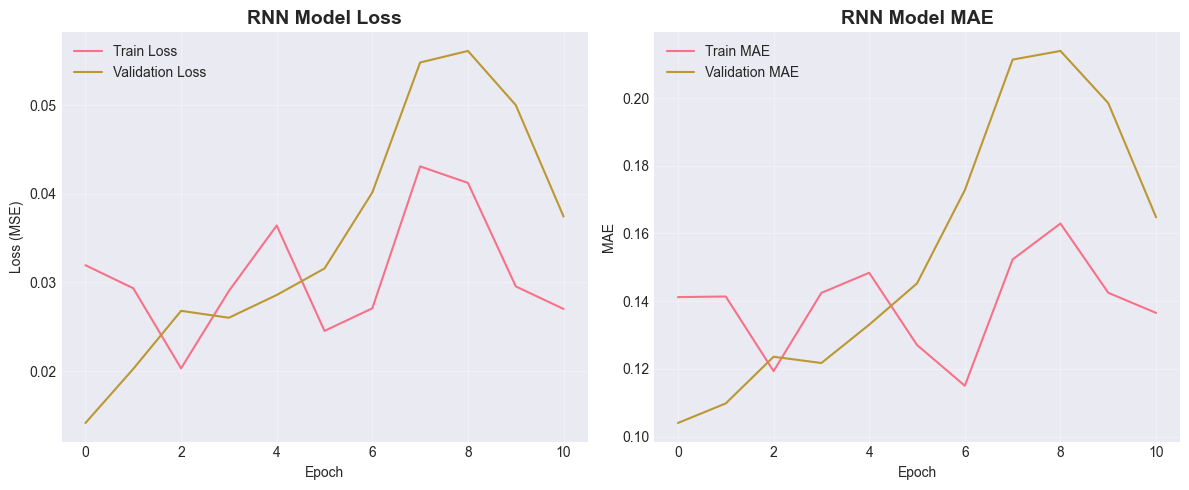


✓ RNN model complete!


In [12]:
import numpy as np
import pandas as pd
import pickle
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

print("=== Building RNN Model ===\n")

# Load the scaled data
X_train_scaled = np.load(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\X_train_scaled.npy')
X_test_scaled = np.load(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\X_test_scaled.npy')
y_train_scaled = np.load(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\y_train_scaled.npy')
y_test_scaled = np.load(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\y_test_scaled.npy')

# Reshape for RNN [samples, timesteps, features]
X_train_rnn = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_rnn = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

print(f"X_train_rnn shape: {X_train_rnn.shape}")
print(f"X_test_rnn shape: {X_test_rnn.shape}")

# Build RNN model
model_rnn = Sequential([
    SimpleRNN(50, activation='relu', return_sequences=True, input_shape=(1, X_train_scaled.shape[1])),
    Dropout(0.2),
    SimpleRNN(50, activation='relu'),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)
])

# Compile model
model_rnn.compile(optimizer='adam', loss='mse', metrics=['mae'])

print("\n--- RNN Model Architecture ---")
model_rnn.summary()

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
print("\n--- Training RNN Model ---")
history_rnn = model_rnn.fit(
    X_train_rnn, y_train_scaled,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

print("\n✓ RNN training complete!")

# Make predictions
y_train_pred_rnn_scaled = model_rnn.predict(X_train_rnn)
y_test_pred_rnn_scaled = model_rnn.predict(X_test_rnn)

# Load scaler to inverse transform
with open(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\scaler_y.pkl', 'rb') as f:
    scaler_y = pickle.load(f)

# Inverse transform predictions
y_train_pred_rnn = scaler_y.inverse_transform(y_train_pred_rnn_scaled)
y_test_pred_rnn = scaler_y.inverse_transform(y_test_pred_rnn_scaled)

# Save predictions
np.save(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\y_train_pred_rnn.npy', y_train_pred_rnn)
np.save(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\y_test_pred_rnn.npy', y_test_pred_rnn)

# Save model
model_rnn.save(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\rnn_model.h5')

print("✓ Saved RNN predictions and model!")

# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_rnn.history['loss'], label='Train Loss')
plt.plot(history_rnn.history['val_loss'], label='Validation Loss')
plt.title('RNN Model Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_rnn.history['mae'], label='Train MAE')
plt.plot(history_rnn.history['val_mae'], label='Validation MAE')
plt.title('RNN Model MAE', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\rnn_training_history.png', dpi=300)
plt.show()

print("\n✓ RNN model complete!")

=== Building ARIMA Model ===

Train data points: 34
Test data points: 9

--- Training ARIMA Model ---
Trying ARIMA order: (5, 1, 0)

--- ARIMA Model Summary ---
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   34
Model:                 ARIMA(5, 1, 0)   Log Likelihood                 -98.014
Date:                Tue, 25 Nov 2025   AIC                            208.027
Time:                        16:20:03   BIC                            217.006
Sample:                             0   HQIC                           211.049
                                 - 34                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0255      0.172     -0.148      

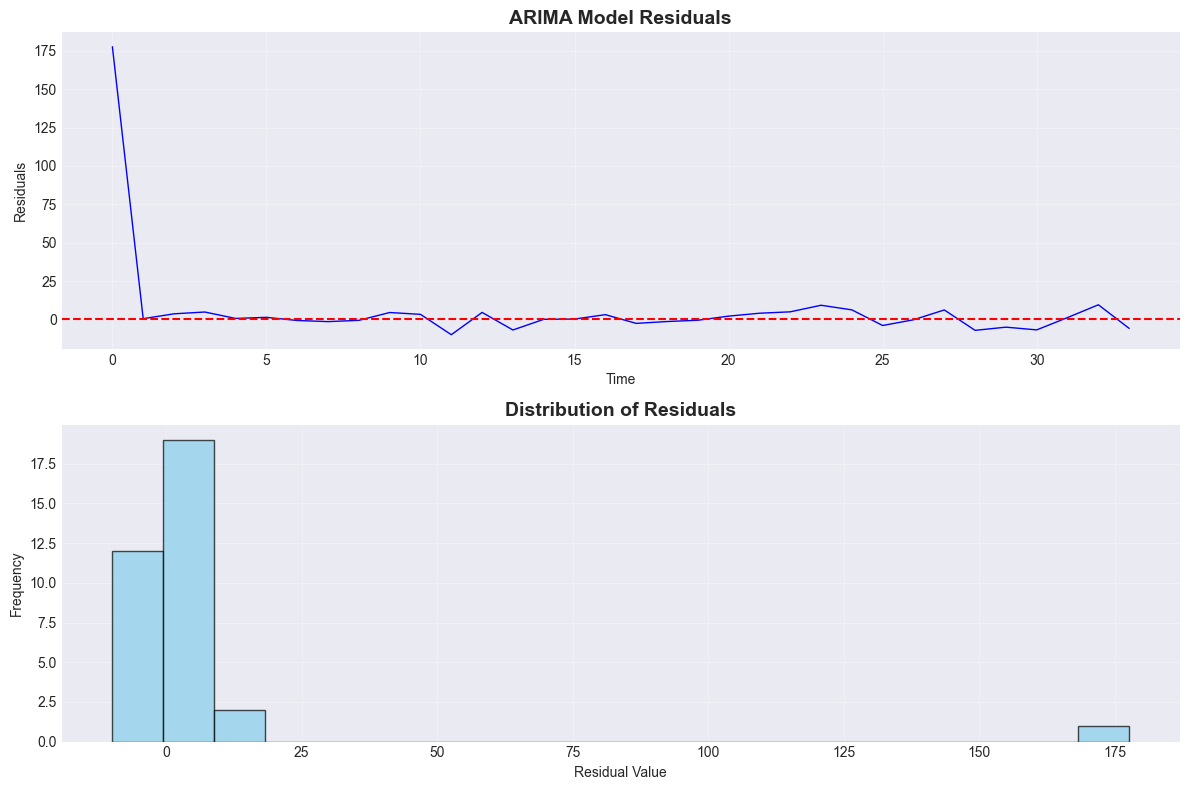


✓ ARIMA model complete!


In [13]:
import numpy as np
import pandas as pd
import pickle
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("=== Building ARIMA Model ===\n")

# Load train and test dates with actual Close prices
train_dates = pd.read_csv(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\train_dates.csv')
test_dates = pd.read_csv(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\test_dates.csv')

train_dates['Date'] = pd.to_datetime(train_dates['Date'])
test_dates['Date'] = pd.to_datetime(test_dates['Date'])

# Get train and test close prices
y_train = train_dates['Close'].values
y_test = test_dates['Close'].values

print(f"Train data points: {len(y_train)}")
print(f"Test data points: {len(y_test)}")

# ARIMA parameters (p, d, q)
# p = autoregressive order
# d = differencing order
# q = moving average order
# Common starting point: (5, 1, 0) or (1, 1, 1)

print("\n--- Training ARIMA Model ---")
print("Trying ARIMA order: (5, 1, 0)")

# Fit ARIMA model on training data
model_arima = ARIMA(y_train, order=(5, 1, 0))
fitted_arima = model_arima.fit()

print("\n--- ARIMA Model Summary ---")
print(fitted_arima.summary())

# Make predictions on training data
y_train_pred_arima = fitted_arima.fittedvalues

# Forecast on test data
y_test_pred_arima = fitted_arima.forecast(steps=len(y_test))

print("\n✓ ARIMA predictions complete!")

# Save predictions
np.save(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\y_train_pred_arima.npy', y_train_pred_arima)
np.save(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\y_test_pred_arima.npy', y_test_pred_arima)

# Save model
with open(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\arima_model.pkl', 'wb') as f:
    pickle.dump(fitted_arima, f)

print("✓ Saved ARIMA predictions and model!")

# Plot ARIMA residuals
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Residuals plot
residuals = fitted_arima.resid
axes[0].plot(residuals, color='blue', linewidth=1)
axes[0].axhline(y=0, color='red', linestyle='--')
axes[0].set_title('ARIMA Model Residuals', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Residuals')
axes[0].grid(True, alpha=0.3)

# Residuals histogram
axes[1].hist(residuals, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
axes[1].set_title('Distribution of Residuals', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Residual Value')
axes[1].set_ylabel('Frequency')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\arima_residuals.png', dpi=300)
plt.show()

print("\n✓ ARIMA model complete!")

=== Building Prophet Model ===

Train data points: 34
Test data points: 9

--- Training Prophet Model ---
✓ Prophet training complete!
✓ Prophet predictions complete!
✓ Saved Prophet predictions and model!


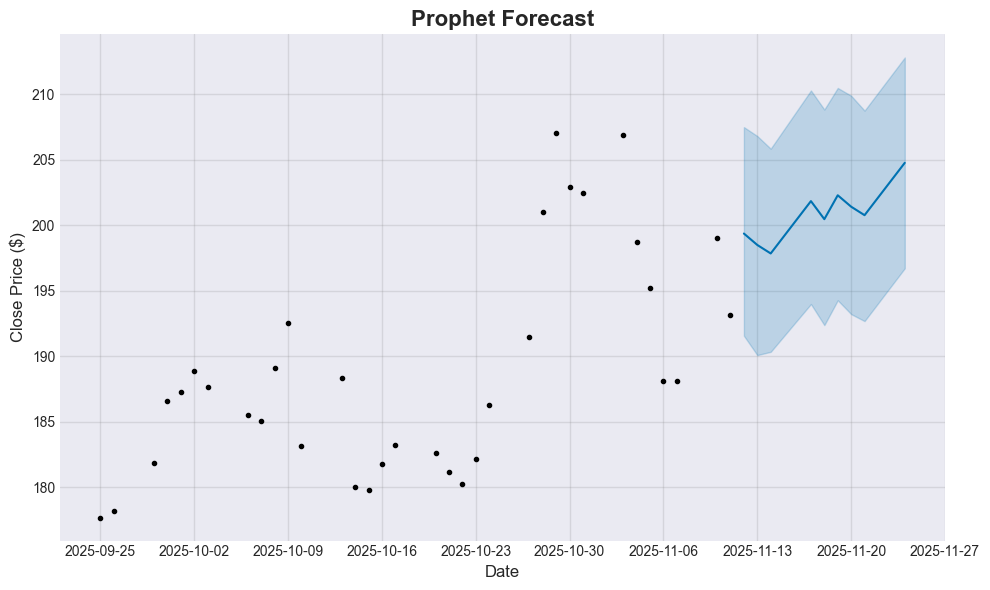

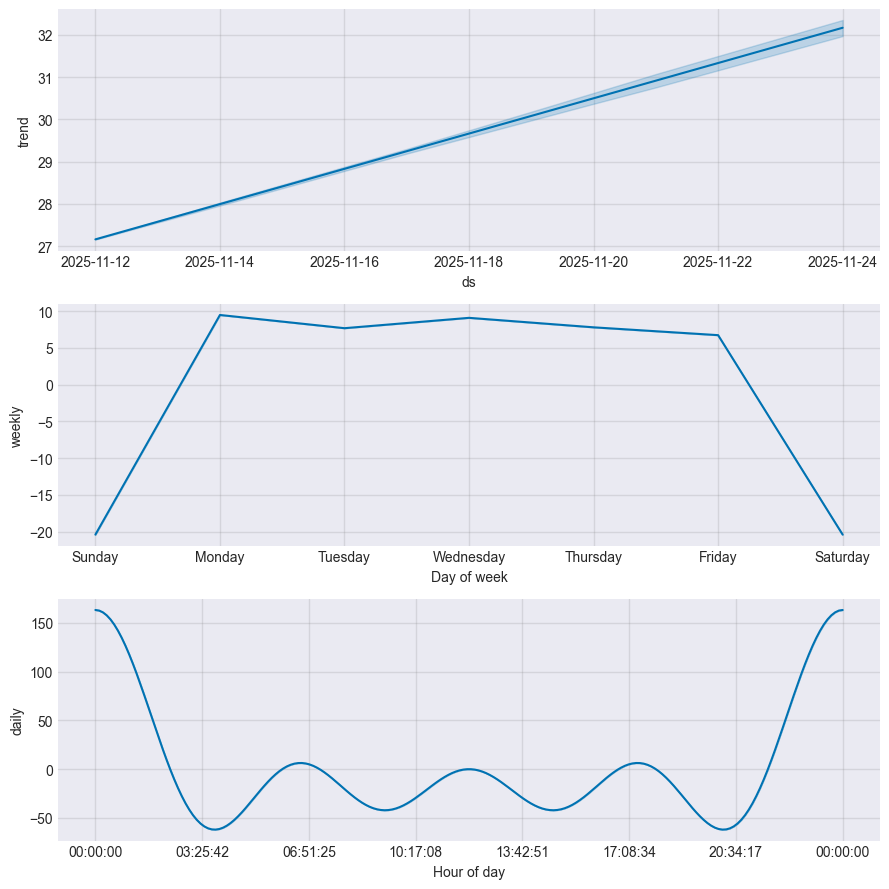


✓ Prophet model complete!

🎉 All 4 models trained successfully!
   - LSTM ✓
   - RNN ✓
   - ARIMA ✓
   - Prophet ✓


In [14]:
import numpy as np
import pandas as pd
import pickle
from prophet import Prophet
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("=== Building Prophet Model ===\n")

# Load train and test dates with actual Close prices
train_dates = pd.read_csv(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\train_dates.csv')
test_dates = pd.read_csv(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\test_dates.csv')

train_dates['Date'] = pd.to_datetime(train_dates['Date'])
test_dates['Date'] = pd.to_datetime(test_dates['Date'])

print(f"Train data points: {len(train_dates)}")
print(f"Test data points: {len(test_dates)}")

# Prophet requires specific column names: 'ds' (date) and 'y' (target)
train_prophet = train_dates.rename(columns={'Date': 'ds', 'Close': 'y'})
test_prophet = test_dates.rename(columns={'Date': 'ds', 'Close': 'y'})

print("\n--- Training Prophet Model ---")

# Initialize and fit Prophet model
model_prophet = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=False,  # Not enough data for yearly
    changepoint_prior_scale=0.05
)

model_prophet.fit(train_prophet)

print("✓ Prophet training complete!")

# Make predictions on training data
train_forecast = model_prophet.predict(train_prophet[['ds']])
y_train_pred_prophet = train_forecast['yhat'].values

# Make predictions on test data
test_forecast = model_prophet.predict(test_prophet[['ds']])
y_test_pred_prophet = test_forecast['yhat'].values

print("✓ Prophet predictions complete!")

# Save predictions
np.save(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\y_train_pred_prophet.npy', y_train_pred_prophet)
np.save(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\y_test_pred_prophet.npy', y_test_pred_prophet)

# Save model
with open(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\prophet_model.pkl', 'wb') as f:
    pickle.dump(model_prophet, f)

print("✓ Saved Prophet predictions and model!")

# Plot Prophet forecast
fig1 = model_prophet.plot(test_forecast)
plt.title('Prophet Forecast', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price ($)', fontsize=12)
plt.tight_layout()
plt.savefig(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\prophet_forecast.png', dpi=300)
plt.show()

# Plot Prophet components
fig2 = model_prophet.plot_components(test_forecast)
plt.tight_layout()
plt.savefig(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\prophet_components.png', dpi=300)
plt.show()

print("\n✓ Prophet model complete!")
print("\n🎉 All 4 models trained successfully!")
print("   - LSTM ✓")
print("   - RNN ✓")
print("   - ARIMA ✓")
print("   - Prophet ✓")

=== Model Evaluation & Comparative Analysis ===

Shape check:
y_train: (34,), y_train_pred_arima: (34,)
y_test: (9,), y_test_pred_arima: (9,)

--- LSTM (Train) ---
MSE:  17.4846
RMSE: 4.1815
MAE:  3.5926
MAPE: 1.91%

--- LSTM (Test) ---
MSE:  33.4096
RMSE: 5.7801
MAE:  4.8121
MAPE: 2.64%

--- RNN (Train) ---
MSE:  18.7815
RMSE: 4.3338
MAE:  3.3569
MAPE: 1.75%

--- RNN (Test) ---
MSE:  6.1470
RMSE: 2.4793
MAE:  1.9838
MAPE: 1.08%

--- ARIMA (Train) ---
MSE:  950.1613
RMSE: 30.8247
MAE:  8.8551
MAPE: 4.83%

--- ARIMA (Test) ---
MSE:  96.0713
RMSE: 9.8016
MAE:  8.7541
MAPE: 4.79%

--- Prophet (Train) ---
MSE:  39.8536
RMSE: 6.3130
MAE:  5.2387
MAPE: 2.75%

--- Prophet (Test) ---
MSE:  274.9449
RMSE: 16.5815
MAE:  15.5381
MAPE: 8.46%

COMPARATIVE ANALYSIS - TEST SET PERFORMANCE
  Model Dataset        MSE      RMSE       MAE     MAPE
    RNN    Test   6.147008  2.479316  1.983847 1.079239
   LSTM    Test  33.409619  5.780105  4.812115 2.636204
  ARIMA    Test  96.071277  9.801596  8.754065 

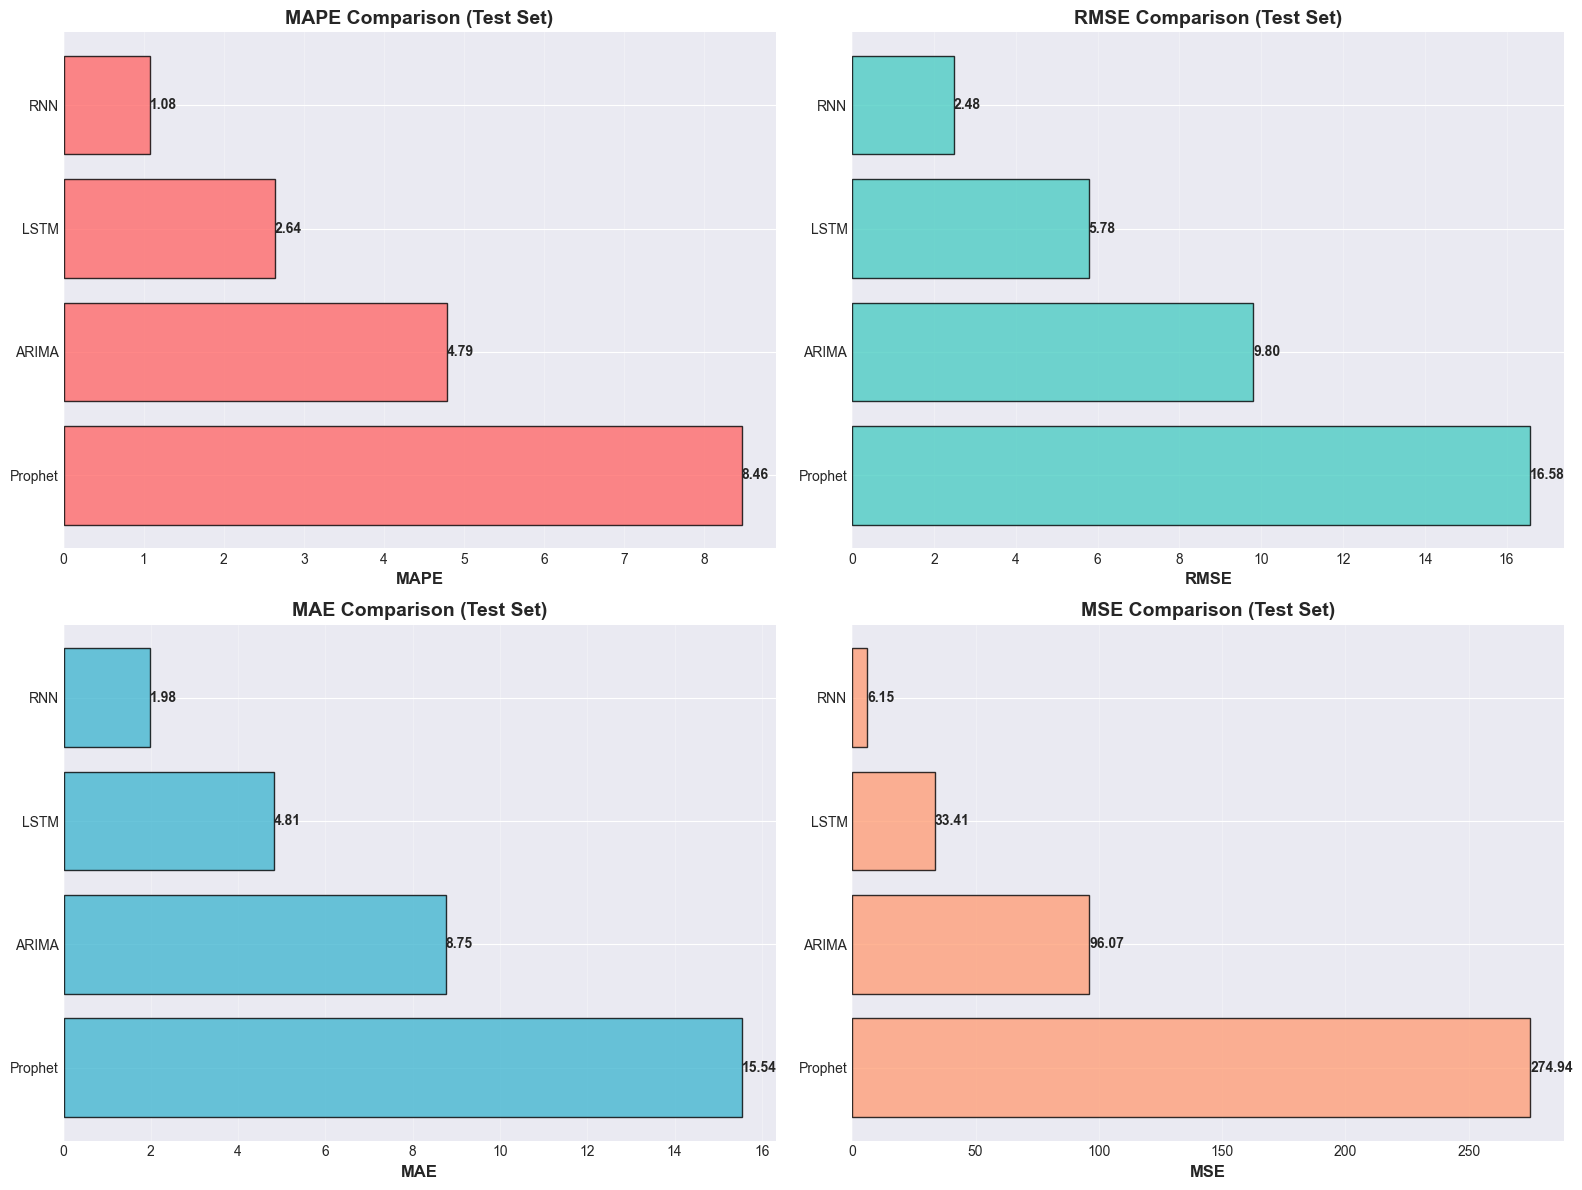


✓ Created comparison visualizations!


In [16]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

print("=== Model Evaluation & Comparative Analysis ===\n")

# Load actual values
y_train = np.load(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\y_train.npy')
y_test = np.load(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\y_test.npy')

# Load predictions from all models
y_train_pred_lstm = np.load(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\y_train_pred_lstm.npy').flatten()
y_test_pred_lstm = np.load(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\y_test_pred_lstm.npy').flatten()

y_train_pred_rnn = np.load(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\y_train_pred_rnn.npy').flatten()
y_test_pred_rnn = np.load(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\y_test_pred_rnn.npy').flatten()

y_train_pred_arima = np.load(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\y_train_pred_arima.npy').flatten()
y_test_pred_arima = np.load(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\y_test_pred_arima.npy').flatten()

y_train_pred_prophet = np.load(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\y_train_pred_prophet.npy').flatten()
y_test_pred_prophet = np.load(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\y_test_pred_prophet.npy').flatten()

# Check shapes
print("Shape check:")
print(f"y_train: {y_train.shape}, y_train_pred_arima: {y_train_pred_arima.shape}")
print(f"y_test: {y_test.shape}, y_test_pred_arima: {y_test_pred_arima.shape}")

# Align ARIMA predictions with actual values
# ARIMA fitted values might be shorter due to differencing
if len(y_train_pred_arima) < len(y_train):
    print(f"\nAligning ARIMA train predictions (removing first {len(y_train) - len(y_train_pred_arima)} values from y_train)")
    y_train_arima_aligned = y_train[len(y_train) - len(y_train_pred_arima):]
else:
    y_train_arima_aligned = y_train

# Define evaluation metrics functions
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculate MAPE"""
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def calculate_metrics(y_true, y_pred, model_name, dataset_type):
    """Calculate all metrics for a model"""
    # Ensure same length
    min_len = min(len(y_true), len(y_pred))
    y_true = y_true[:min_len]
    y_pred = y_pred[:min_len]
    
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    
    print(f"\n--- {model_name} ({dataset_type}) ---")
    print(f"MSE:  {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"MAPE: {mape:.2f}%")
    
    return {'Model': model_name, 'Dataset': dataset_type, 
            'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape}

# Calculate metrics for all models
results = []

# LSTM
results.append(calculate_metrics(y_train, y_train_pred_lstm, 'LSTM', 'Train'))
results.append(calculate_metrics(y_test, y_test_pred_lstm, 'LSTM', 'Test'))

# RNN
results.append(calculate_metrics(y_train, y_train_pred_rnn, 'RNN', 'Train'))
results.append(calculate_metrics(y_test, y_test_pred_rnn, 'RNN', 'Test'))

# ARIMA (with aligned data)
results.append(calculate_metrics(y_train_arima_aligned, y_train_pred_arima, 'ARIMA', 'Train'))
results.append(calculate_metrics(y_test, y_test_pred_arima, 'ARIMA', 'Test'))

# Prophet
results.append(calculate_metrics(y_train, y_train_pred_prophet, 'Prophet', 'Train'))
results.append(calculate_metrics(y_test, y_test_pred_prophet, 'Prophet', 'Test'))

# Create results DataFrame
results_df = pd.DataFrame(results)

# Separate train and test results
test_results = results_df[results_df['Dataset'] == 'Test'].copy()
test_results = test_results.sort_values('MAPE')

print("\n" + "="*70)
print("COMPARATIVE ANALYSIS - TEST SET PERFORMANCE")
print("="*70)
print(test_results.to_string(index=False))

# Find best model
best_model = test_results.iloc[0]['Model']
best_mape = test_results.iloc[0]['MAPE']

print("\n" + "="*70)
print(f"🏆 BEST MODEL: {best_model}")
print(f"   Test MAPE: {best_mape:.2f}%")
if best_mape < 5:
    print(f"   ✓ Target achieved! (MAPE < 5%)")
else:
    print(f"   ✗ Target not met (MAPE goal: < 5%)")
print("="*70)

# Save results
results_df.to_csv(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\model_comparison_results.csv', index=False)
print("\n✓ Saved results to 'model_comparison_results.csv'")

# Visualization: Comparative Bar Charts
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['MAPE', 'RMSE', 'MAE', 'MSE']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    
    data = test_results.sort_values(metric)
    bars = ax.barh(data['Model'], data[metric], color=colors[idx], alpha=0.8, edgecolor='black')
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2, 
                f'{width:.2f}', ha='left', va='center', fontweight='bold', fontsize=10)
    
    ax.set_xlabel(metric, fontsize=12, fontweight='bold')
    ax.set_title(f'{metric} Comparison (Test Set)', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')
    
    ax.invert_yaxis()

plt.tight_layout()
plt.savefig(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\model_comparison_metrics.png', dpi=300)
plt.show()

print("\n✓ Created comparison visualizations!")

=== Creating Train vs Predicted & Test vs Predicted Charts ===



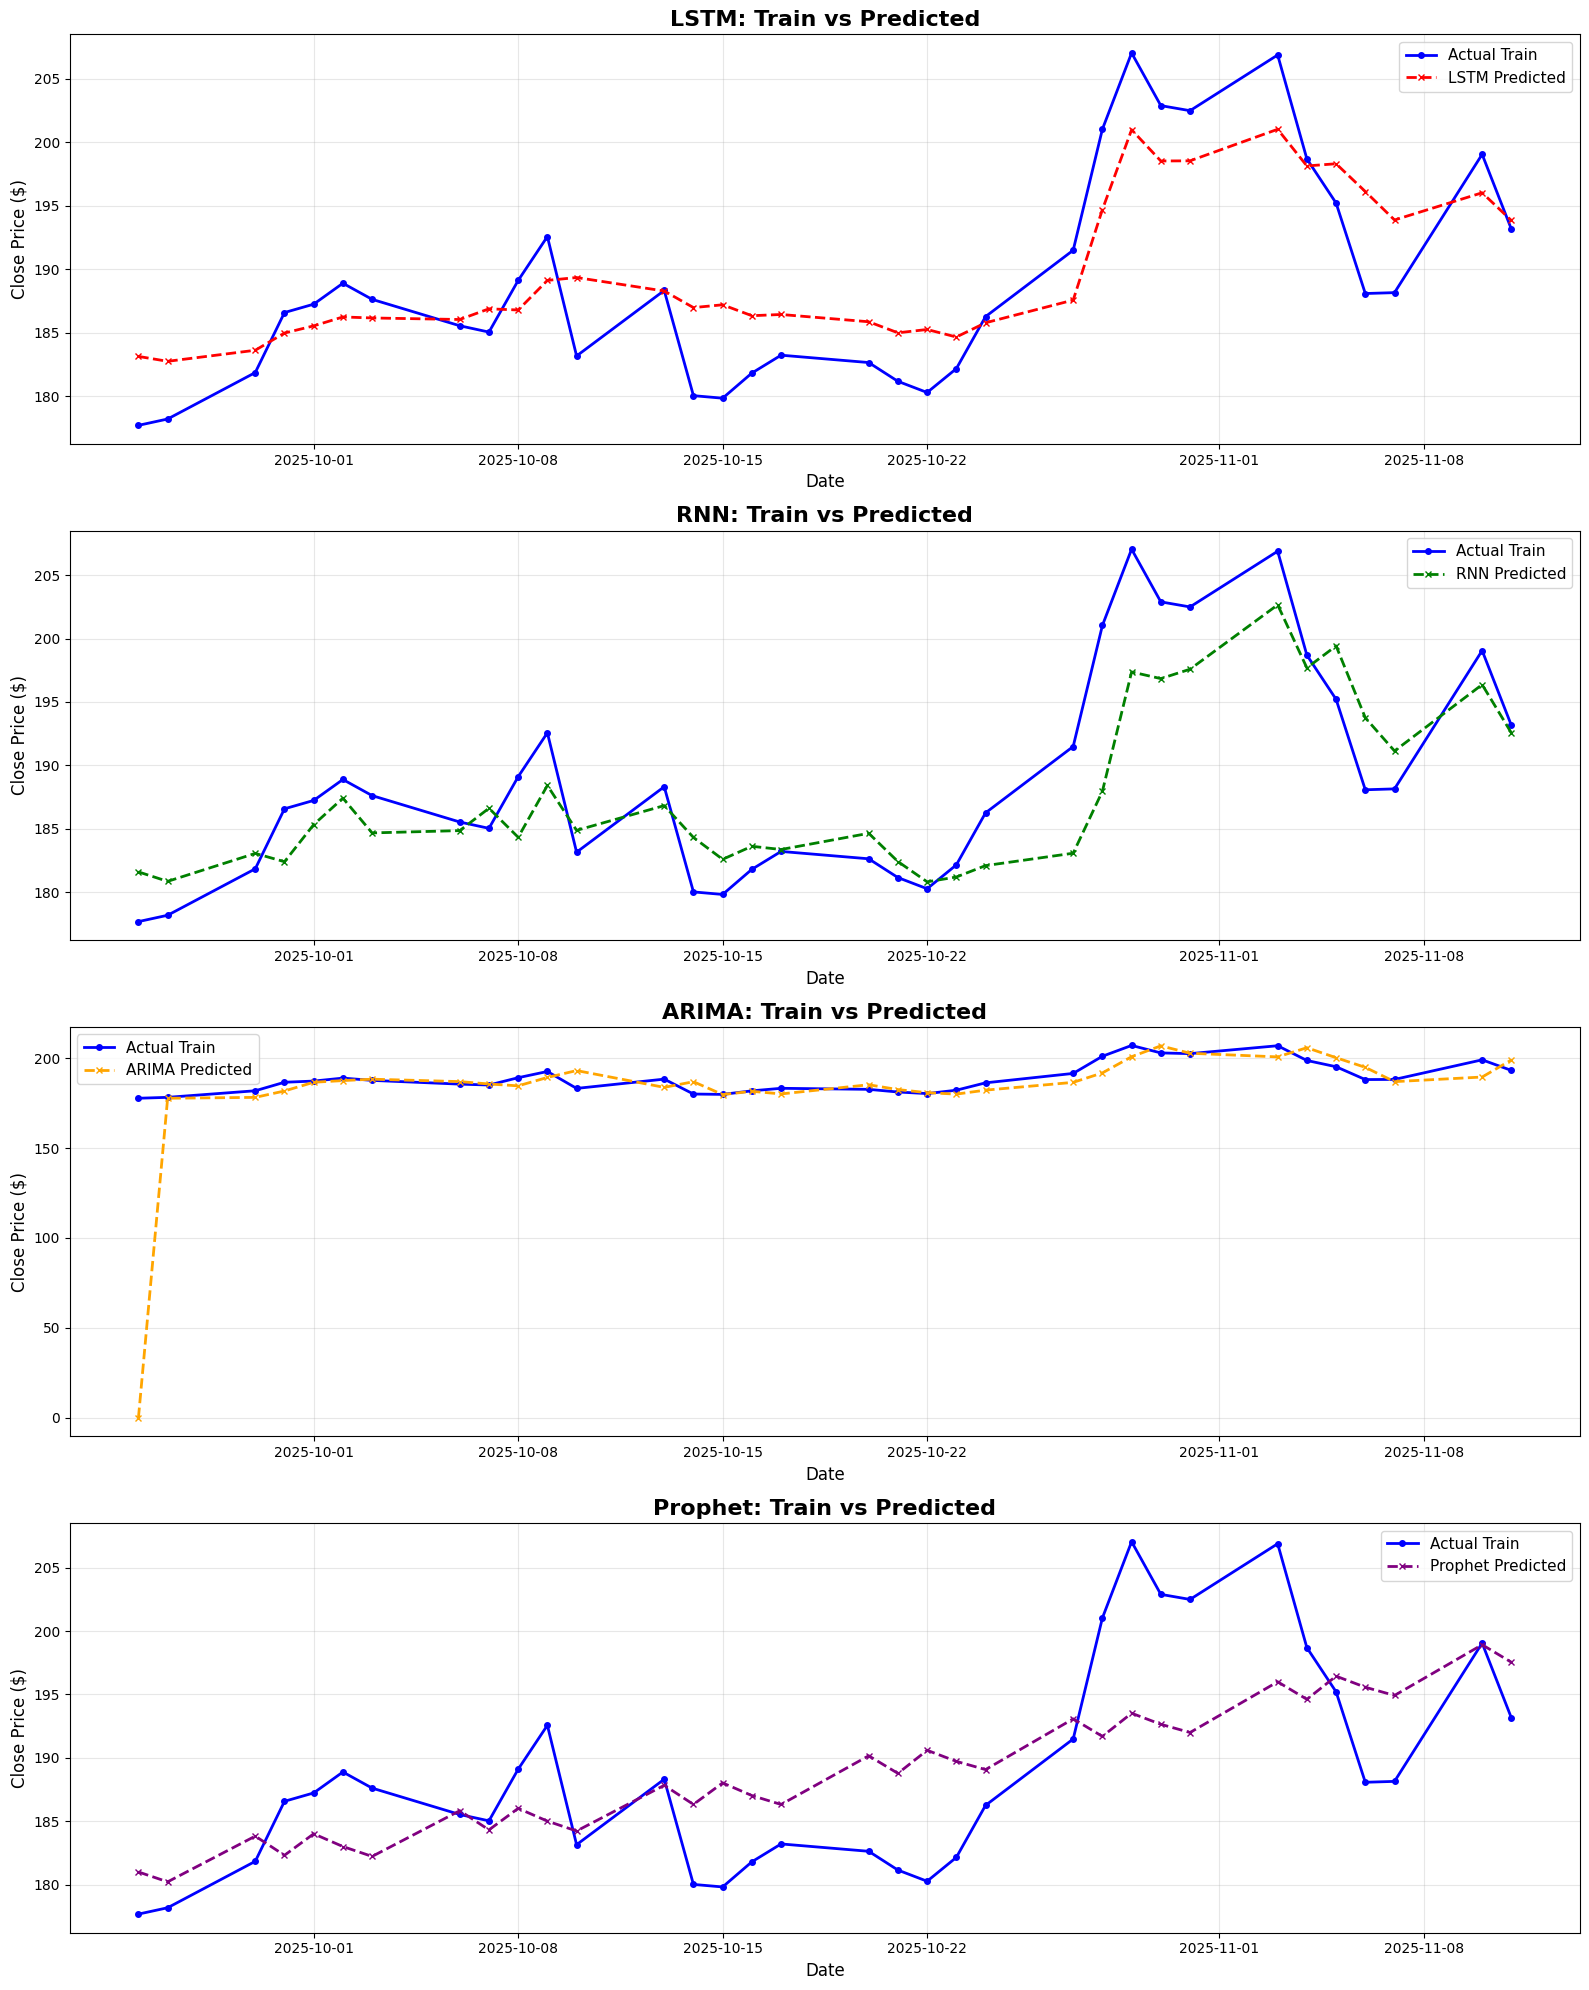

✓ Saved: train_vs_predicted_all_models.png


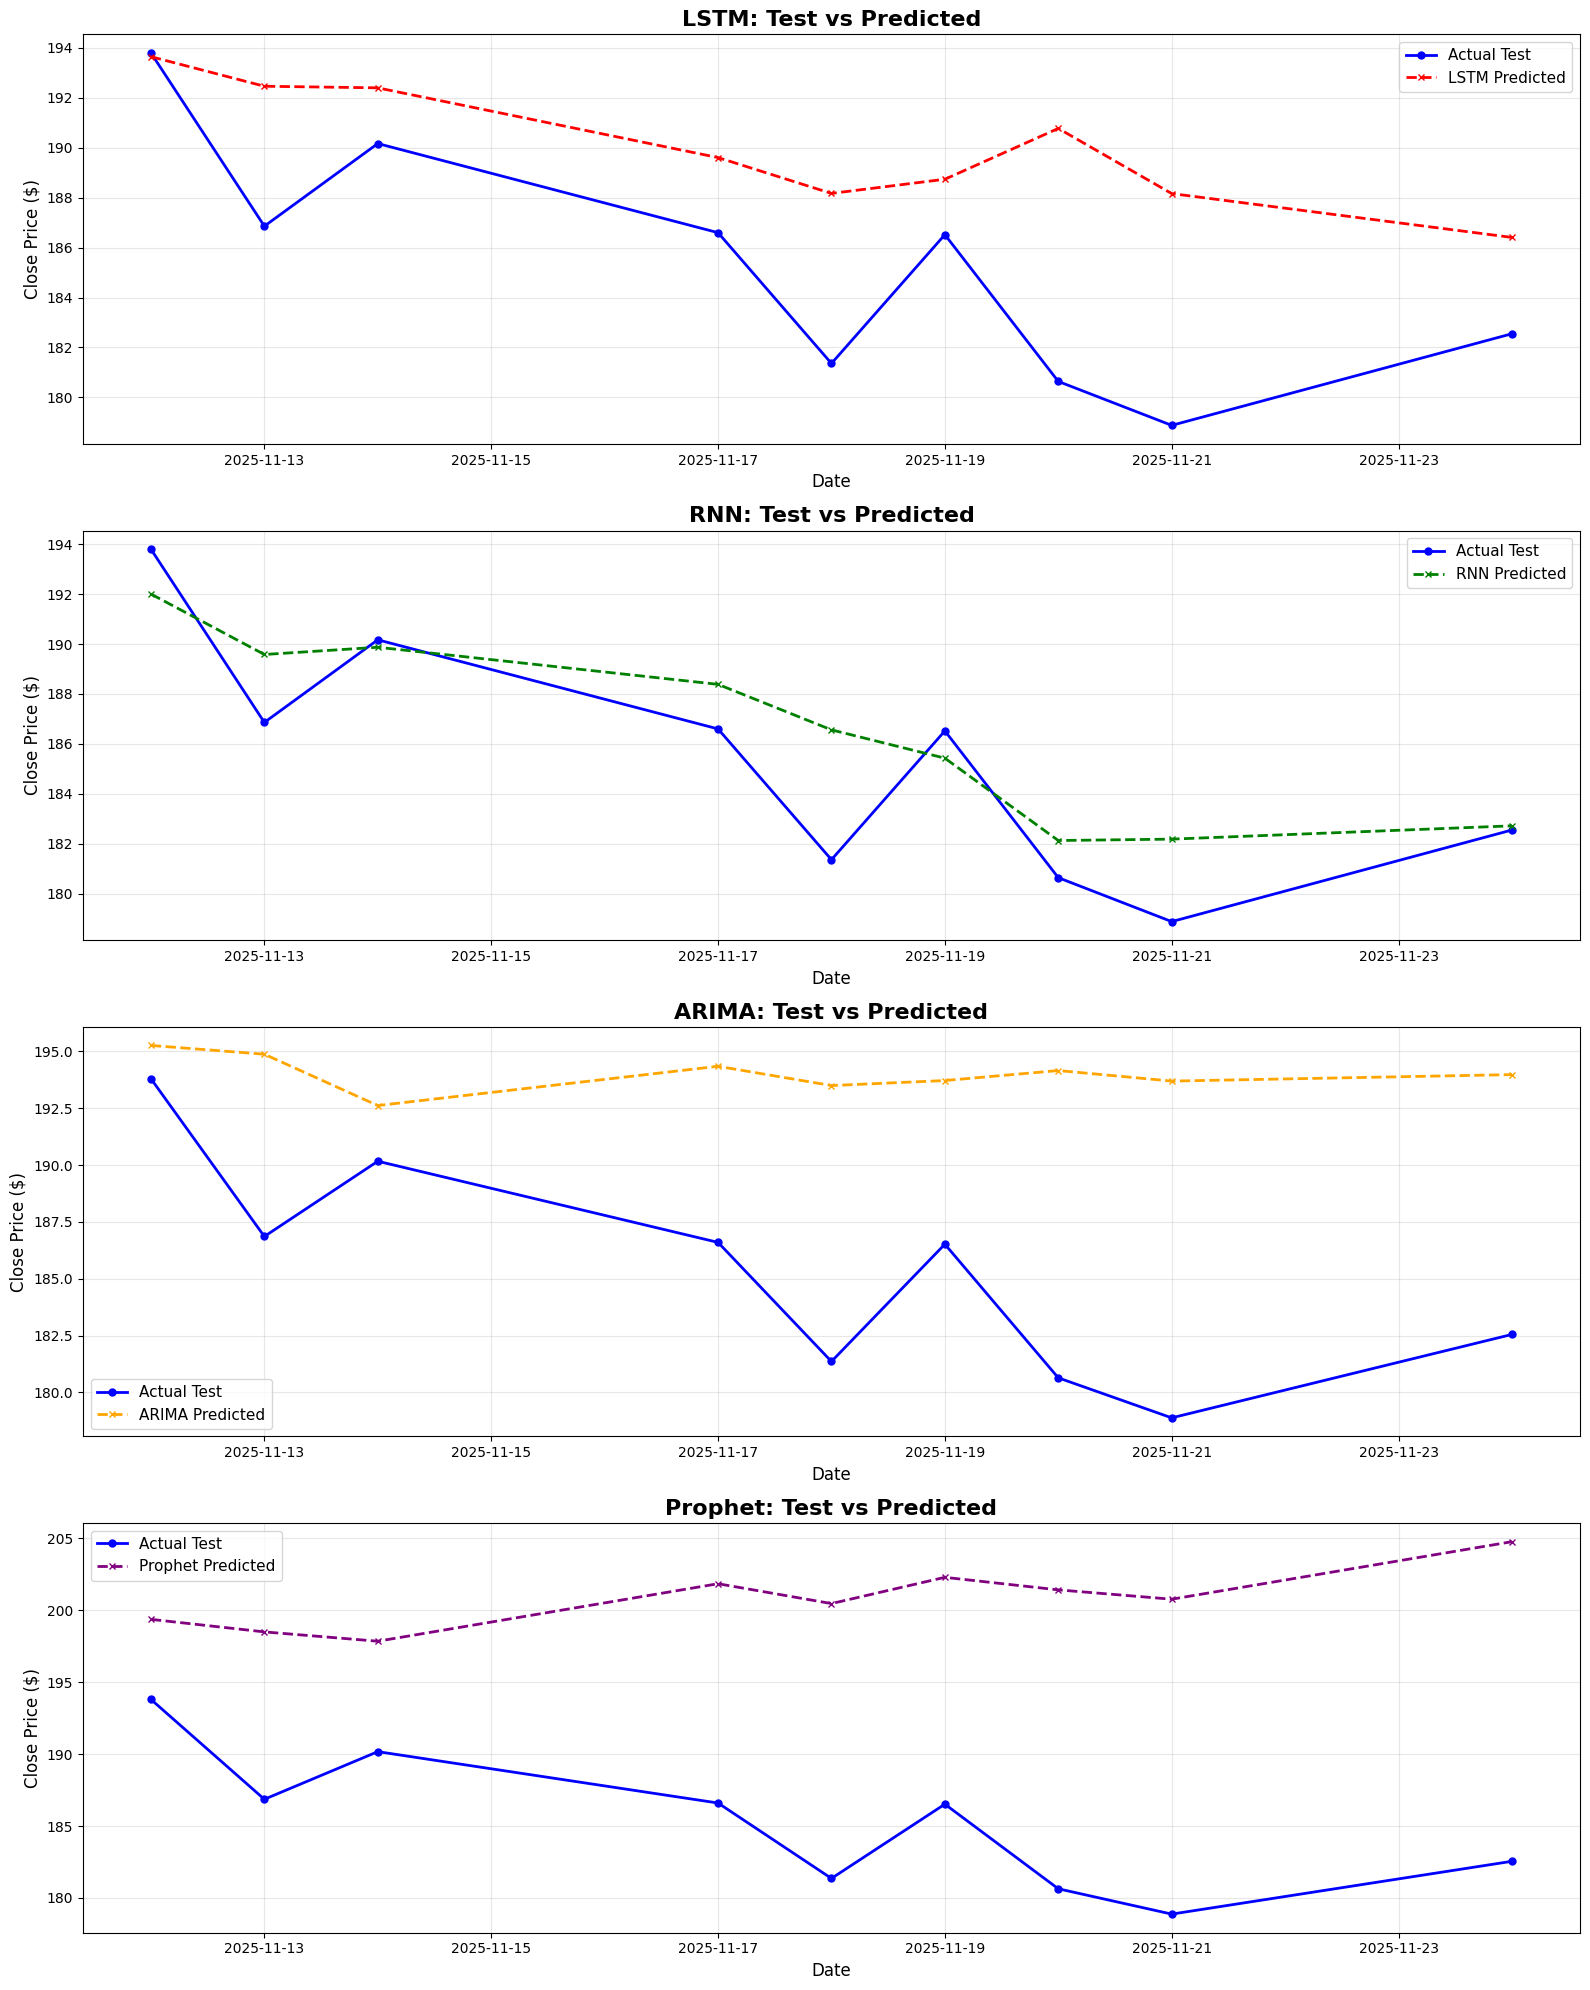

✓ Saved: test_vs_predicted_all_models.png

🎉 ALL VISUALIZATIONS COMPLETE!

Files created:
- train_vs_predicted_all_models.png
- test_vs_predicted_all_models.png

✓ Project complete! Ready for GitHub!


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("=== Creating Train vs Predicted & Test vs Predicted Charts ===\n")

# Load actual values
y_train = np.load(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\y_train.npy')
y_test = np.load(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\y_test.npy')

# Load dates
train_dates = pd.read_csv(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\train_dates.csv')
test_dates = pd.read_csv(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\test_dates.csv')
train_dates['Date'] = pd.to_datetime(train_dates['Date'])
test_dates['Date'] = pd.to_datetime(test_dates['Date'])

# Load all predictions
y_train_pred_lstm = np.load(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\y_train_pred_lstm.npy').flatten()
y_test_pred_lstm = np.load(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\y_test_pred_lstm.npy').flatten()

y_train_pred_rnn = np.load(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\y_train_pred_rnn.npy').flatten()
y_test_pred_rnn = np.load(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\y_test_pred_rnn.npy').flatten()

y_train_pred_arima = np.load(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\y_train_pred_arima.npy').flatten()
y_test_pred_arima = np.load(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\y_test_pred_arima.npy').flatten()

y_train_pred_prophet = np.load(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\y_train_pred_prophet.npy').flatten()
y_test_pred_prophet = np.load(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\y_test_pred_prophet.npy').flatten()

# Handle ARIMA length mismatch for train
if len(y_train_pred_arima) < len(y_train):
    train_dates_arima = train_dates.iloc[len(y_train) - len(y_train_pred_arima):].reset_index(drop=True)
    y_train_arima = y_train[len(y_train) - len(y_train_pred_arima):]
else:
    train_dates_arima = train_dates
    y_train_arima = y_train

# ========== TRAIN VS PREDICTED CHARTS ==========

fig, axes = plt.subplots(4, 1, figsize=(16, 20))

# LSTM - Train vs Predicted
axes[0].plot(train_dates['Date'], y_train, label='Actual Train', linewidth=2, color='blue', marker='o', markersize=4)
axes[0].plot(train_dates['Date'], y_train_pred_lstm, label='LSTM Predicted', linewidth=2, color='red', linestyle='--', marker='x', markersize=4)
axes[0].set_title('LSTM: Train vs Predicted', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Close Price ($)', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# RNN - Train vs Predicted
axes[1].plot(train_dates['Date'], y_train, label='Actual Train', linewidth=2, color='blue', marker='o', markersize=4)
axes[1].plot(train_dates['Date'], y_train_pred_rnn, label='RNN Predicted', linewidth=2, color='green', linestyle='--', marker='x', markersize=4)
axes[1].set_title('RNN: Train vs Predicted', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Close Price ($)', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

# ARIMA - Train vs Predicted
axes[2].plot(train_dates_arima['Date'], y_train_arima, label='Actual Train', linewidth=2, color='blue', marker='o', markersize=4)
axes[2].plot(train_dates_arima['Date'], y_train_pred_arima, label='ARIMA Predicted', linewidth=2, color='orange', linestyle='--', marker='x', markersize=4)
axes[2].set_title('ARIMA: Train vs Predicted', fontsize=16, fontweight='bold')
axes[2].set_xlabel('Date', fontsize=12)
axes[2].set_ylabel('Close Price ($)', fontsize=12)
axes[2].legend(fontsize=11)
axes[2].grid(True, alpha=0.3)

# Prophet - Train vs Predicted
axes[3].plot(train_dates['Date'], y_train, label='Actual Train', linewidth=2, color='blue', marker='o', markersize=4)
axes[3].plot(train_dates['Date'], y_train_pred_prophet, label='Prophet Predicted', linewidth=2, color='purple', linestyle='--', marker='x', markersize=4)
axes[3].set_title('Prophet: Train vs Predicted', fontsize=16, fontweight='bold')
axes[3].set_xlabel('Date', fontsize=12)
axes[3].set_ylabel('Close Price ($)', fontsize=12)
axes[3].legend(fontsize=11)
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\train_vs_predicted_all_models.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: train_vs_predicted_all_models.png")

# ========== TEST VS PREDICTED CHARTS ==========

fig, axes = plt.subplots(4, 1, figsize=(16, 20))

# LSTM - Test vs Predicted
axes[0].plot(test_dates['Date'], y_test, label='Actual Test', linewidth=2, color='blue', marker='o', markersize=5)
axes[0].plot(test_dates['Date'], y_test_pred_lstm, label='LSTM Predicted', linewidth=2, color='red', linestyle='--', marker='x', markersize=5)
axes[0].set_title('LSTM: Test vs Predicted', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Close Price ($)', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# RNN - Test vs Predicted
axes[1].plot(test_dates['Date'], y_test, label='Actual Test', linewidth=2, color='blue', marker='o', markersize=5)
axes[1].plot(test_dates['Date'], y_test_pred_rnn, label='RNN Predicted', linewidth=2, color='green', linestyle='--', marker='x', markersize=5)
axes[1].set_title('RNN: Test vs Predicted', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Close Price ($)', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

# ARIMA - Test vs Predicted
axes[2].plot(test_dates['Date'], y_test, label='Actual Test', linewidth=2, color='blue', marker='o', markersize=5)
axes[2].plot(test_dates['Date'], y_test_pred_arima, label='ARIMA Predicted', linewidth=2, color='orange', linestyle='--', marker='x', markersize=5)
axes[2].set_title('ARIMA: Test vs Predicted', fontsize=16, fontweight='bold')
axes[2].set_xlabel('Date', fontsize=12)
axes[2].set_ylabel('Close Price ($)', fontsize=12)
axes[2].legend(fontsize=11)
axes[2].grid(True, alpha=0.3)

# Prophet - Test vs Predicted
axes[3].plot(test_dates['Date'], y_test, label='Actual Test', linewidth=2, color='blue', marker='o', markersize=5)
axes[3].plot(test_dates['Date'], y_test_pred_prophet, label='Prophet Predicted', linewidth=2, color='purple', linestyle='--', marker='x', markersize=5)
axes[3].set_title('Prophet: Test vs Predicted', fontsize=16, fontweight='bold')
axes[3].set_xlabel('Date', fontsize=12)
axes[3].set_ylabel('Close Price ($)', fontsize=12)
axes[3].legend(fontsize=11)
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(r'C:\Emaad\Nvidia Stocks Data Time-Series Analysis\test_vs_predicted_all_models.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: test_vs_predicted_all_models.png")

print("\n" + "="*70)
print("🎉 ALL VISUALIZATIONS COMPLETE!")
print("="*70)
print("\nFiles created:")
print("- train_vs_predicted_all_models.png")
print("- test_vs_predicted_all_models.png")